# Advanced Tutorial 8: Explainable AI (XAI)

## Overview
In this tutorial, we will discuss the following topics:
* Saliency Maps

## Saliency Maps

Suppose you have a neural network that is performing image classification. The network tells you that the image it is looking at is an airplane, but you want to know whether it is really detecting an airplane, or if it is 'cheating' by noticing the blue sky in the image background. To answer this question, all you need to do is add the Saliency `Trace` to your list of traces, and pass its output to one of either the ImageSaver, ImageViewer, or TensorBoard traces.

In [1]:
import fastestimator as fe
from fastestimator.architecture.tensorflow import LeNet
from fastestimator.backend import squeeze, to_number
from fastestimator.dataset.data import cifar10
from fastestimator.op.numpyop.univariate import Normalize
from fastestimator.op.tensorop.loss import CrossEntropy
from fastestimator.op.tensorop.model import ModelOp, UpdateOp
from fastestimator.schedule import cosine_decay
from fastestimator.trace.adapt import LRScheduler
from fastestimator.trace.io import BestModelSaver, ImageViewer, TensorBoard
from fastestimator.trace.metric import Accuracy
from fastestimator.trace.xai import Saliency

import matplotlib.pyplot as plt
import numpy as np

label_mapping = {
    'airplane': 0,
    'automobile': 1,
    'bird': 2,
    'cat': 3,
    'deer': 4,
    'dog': 5,
    'frog': 6,
    'horse': 7,
    'ship': 8,
    'truck': 9
}

batch_size=32

train_data, eval_data = cifar10.load_data()
test_data = eval_data.split(0.5)
pipeline = fe.Pipeline(
    train_data=train_data,
    eval_data=eval_data,
    test_data=test_data,
    batch_size=batch_size,
    ops=[Normalize(inputs="x", outputs="x")],
    num_process=0)

model = fe.build(model_fn=lambda: LeNet(input_shape=(32, 32, 3)), optimizer_fn="adam")
network = fe.Network(ops=[
    ModelOp(model=model, inputs="x", outputs="y_pred"),
    CrossEntropy(inputs=("y_pred", "y"), outputs="ce"),
    UpdateOp(model=model, loss_name="ce")
])

traces = [
    Accuracy(true_key="y", pred_key="y_pred"),
    LRScheduler(model=model, lr_fn=lambda step: cosine_decay(step, cycle_length=3750, init_lr=1e-3)),
    Saliency(model=model,
             model_inputs="x",
             class_key="y",
             model_outputs="y_pred",
             samples=5,
             label_mapping=label_mapping),
    ImageViewer(inputs="saliency")
]
estimator = fe.Estimator(pipeline=pipeline,
                         network=network,
                         epochs=5,
                         traces=traces,
                         log_steps=1000)

FastEstimator-Warn: No ModelSaver Trace detected. Models will not be saved.


In this example we will be using the ImageViewer `Trace`, since it will allow us to visualize the outputs within this Notebook. If you wanted your images to appear in TensorBoard, simply construct a TensorBoard `Trace` with the "write_images" argument set to "saliency". 

    ______           __  ______     __  _                 __            
   / ____/___ ______/ /_/ ____/____/ /_(_)___ ___  ____ _/ /_____  _____
  / /_  / __ `/ ___/ __/ __/ / ___/ __/ / __ `__ \/ __ `/ __/ __ \/ ___/
 / __/ / /_/ (__  ) /_/ /___(__  ) /_/ / / / / / / /_/ / /_/ /_/ / /    
/_/    \__,_/____/\__/_____/____/\__/_/_/ /_/ /_/\__,_/\__/\____/_/     
                                                                        

FastEstimator-Start: step: 1; model_lr: 0.001; 
FastEstimator-Train: step: 1; ce: 2.4086466; model_lr: 0.001; 
FastEstimator-Train: step: 1000; ce: 1.1492558; steps/sec: 100.75; model_lr: 0.0008350416; 
FastEstimator-Train: step: 1563; epoch: 1; epoch_time: 17.95 sec; 


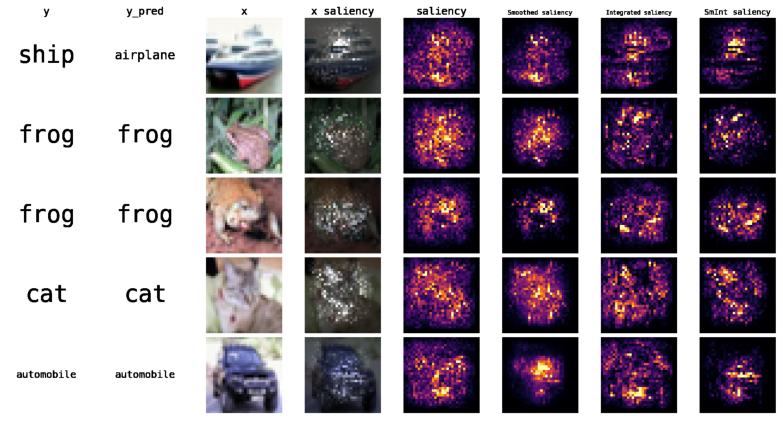

FastEstimator-Eval: step: 1563; epoch: 1; ce: 1.1425381; min_ce: 1.1425381; since_best: 0; accuracy: 0.5918; 
FastEstimator-Train: step: 2000; ce: 0.89284; steps/sec: 92.09; model_lr: 0.00044870423; 
FastEstimator-Train: step: 3000; ce: 1.1099913; steps/sec: 74.32; model_lr: 9.664212e-05; 
FastEstimator-Train: step: 3126; epoch: 2; epoch_time: 20.27 sec; 


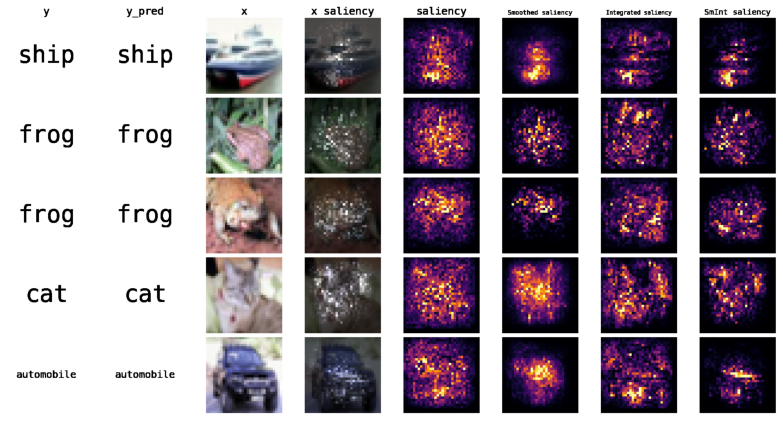

FastEstimator-Eval: step: 3126; epoch: 2; ce: 0.95712155; min_ce: 0.95712155; since_best: 0; accuracy: 0.6644; 
FastEstimator-Train: step: 4000; ce: 1.1009073; steps/sec: 70.47; model_lr: 0.0009891716; 
FastEstimator-Train: step: 4689; epoch: 3; epoch_time: 22.43 sec; 


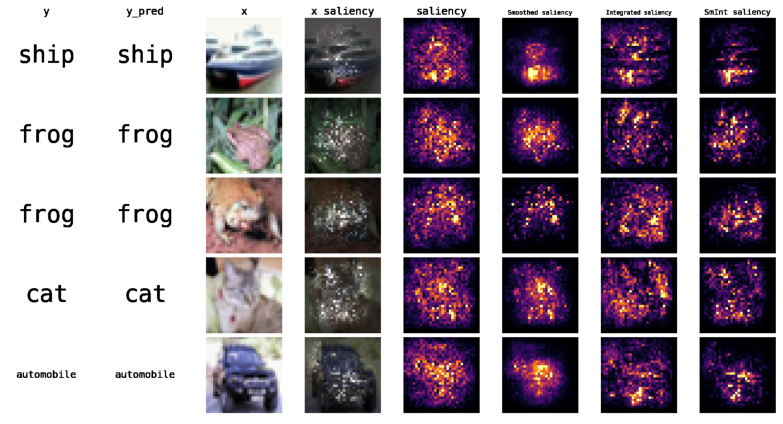

FastEstimator-Eval: step: 4689; epoch: 3; ce: 0.9900876; min_ce: 0.95712155; since_best: 1; accuracy: 0.6496; 
FastEstimator-Train: step: 5000; ce: 0.7491252; steps/sec: 68.2; model_lr: 0.0007506123; 
FastEstimator-Train: step: 6000; ce: 0.7791686; steps/sec: 67.09; model_lr: 0.00034654405; 
FastEstimator-Train: step: 6252; epoch: 4; epoch_time: 23.4 sec; 


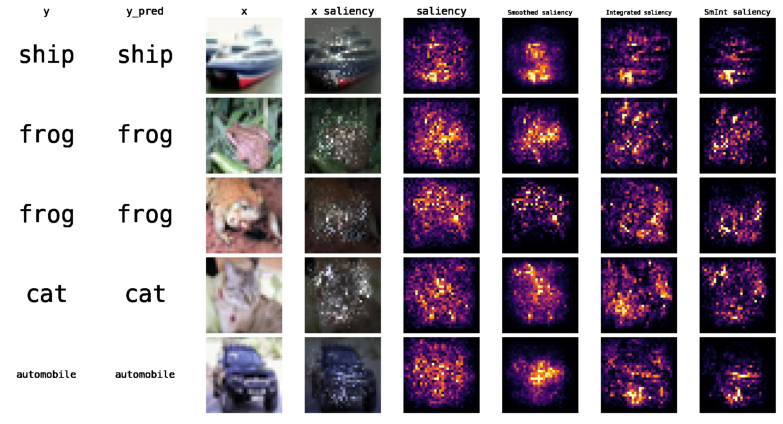

FastEstimator-Eval: step: 6252; epoch: 4; ce: 0.82986677; min_ce: 0.82986677; since_best: 0; accuracy: 0.7128; 
FastEstimator-Train: step: 7000; ce: 0.5820452; steps/sec: 59.78; model_lr: 4.435441e-05; 
FastEstimator-Train: step: 7815; epoch: 5; epoch_time: 26.59 sec; 


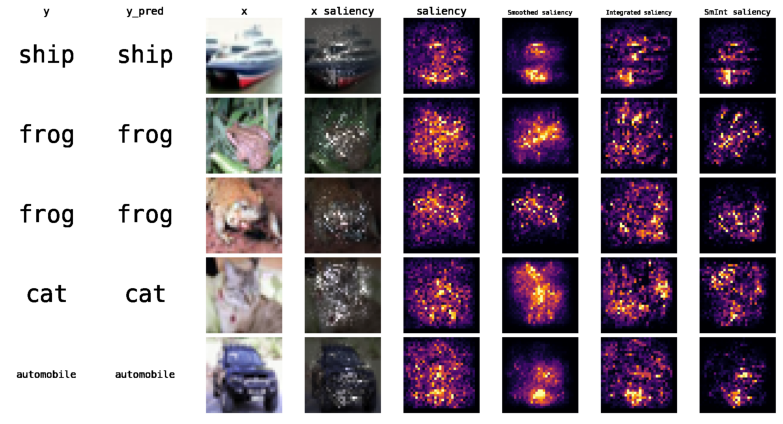

FastEstimator-Eval: step: 7815; epoch: 5; ce: 0.9650825; min_ce: 0.82986677; since_best: 1; accuracy: 0.6658; 
FastEstimator-Finish: step: 7815; total_time: 125.58 sec; model_lr: 0.0009828171; 


In [2]:
estimator.fit()

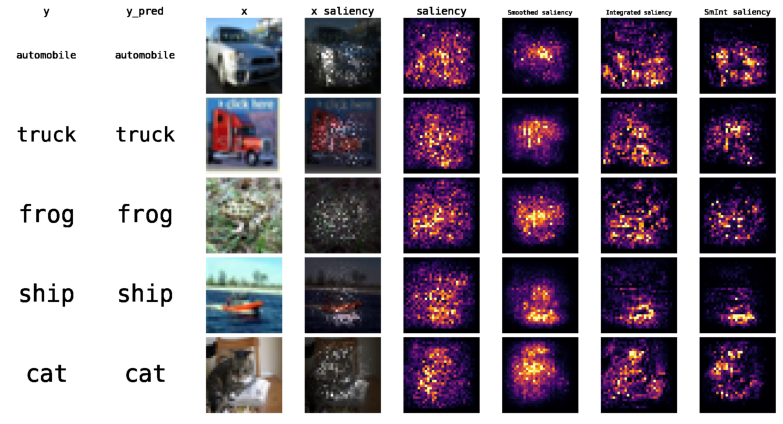

FastEstimator-Test: step: 7815; epoch: 5; accuracy: 0.6596; 


In [3]:
estimator.test()

In the images above, the 'saliency' column corresponds to a raw saliency mask generated by back-propagating a model's output prediction onto the input image. 'Smoothed saliency' combines multiple saliency masks for each image 'x', where each mask is generated by slightly perturbing the input 'x' before running the forward and backward gradient passes. The number of samples to be combined is controlled by the "smoothing" argument in the Saliency `Trace` constructor. 'Integrated saliency' is a saliency mask generated by starting from a baseline blank image and linearly interpolating the image towards 'x' over a number of steps defined by the "integrating" argument in the Saliency constructor. The resulting masks are then combined together. The 'SmInt Saliency' (Smoothed-Integrated) column combines smoothing and integration together. SmInt is generally considered to give the most reliable indication of the important features in an image, but it also takes the longest to compute. It is possible to disable the more complex columns by setting the 'smoothing' and 'integrating' parameters to 0. The 'x saliency' column shows the input image overlaid with whatever saliency column is furthest to the right (SmInt, unless that has been disabled).

## Saliency Maps without Traces

Suppose that you want to generate Saliency masks without using a `Trace`. This can be done through the fe.xai package:

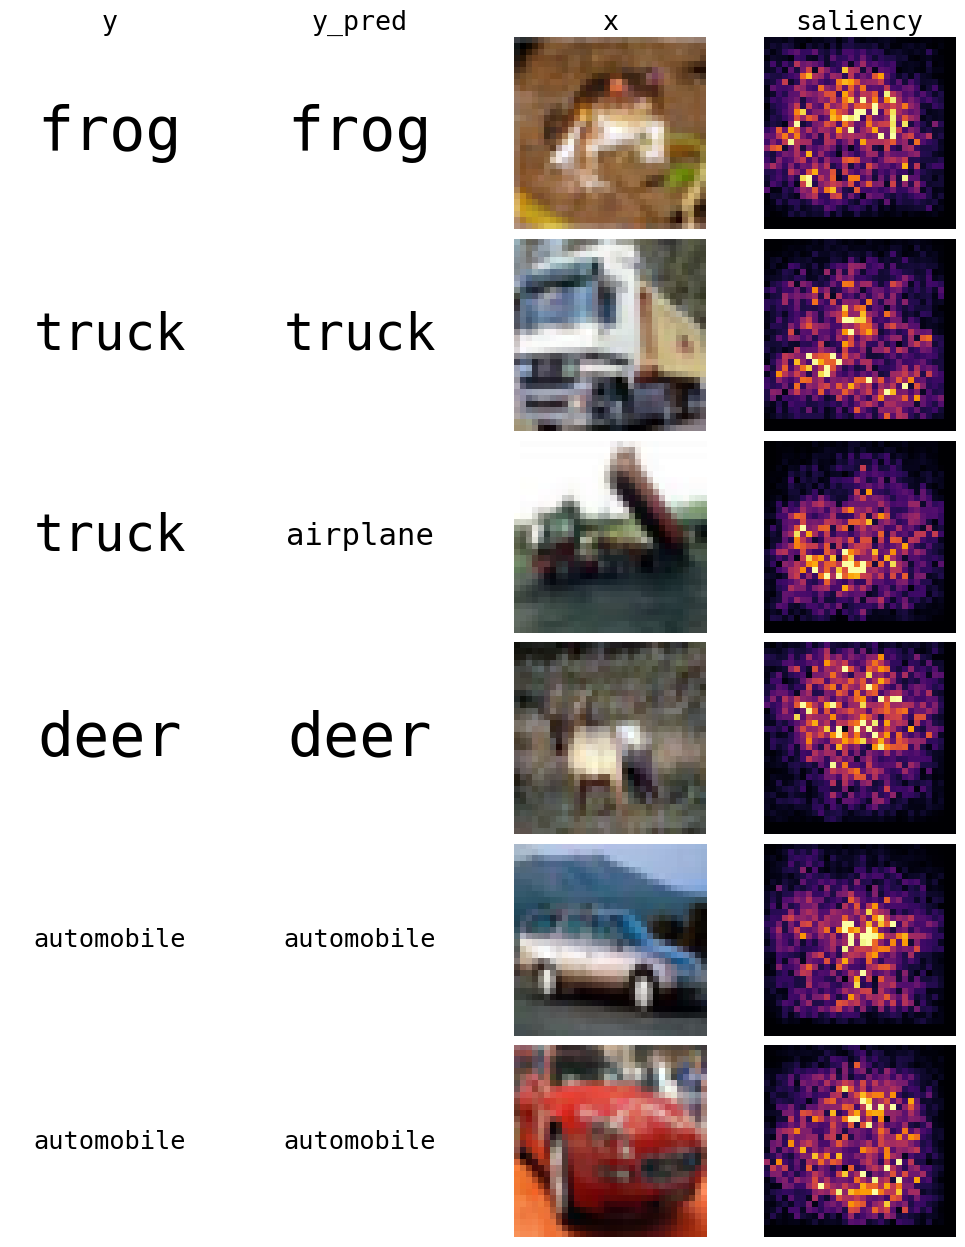

In [4]:
pipeline.batch_size = 6
batch = pipeline.get_results()
batch = fe.backend.to_tensor(batch, "tf")  # Convert the batch to TensorFlow

saliency_generator = fe.xai.SaliencyNet(model=model, model_inputs="x", model_outputs="y_pred")
images = saliency_generator.get_masks(batch=batch)

# Let's convert 'y' and 'y_pred' from numeric values to strings for readability:
val_to_label = {val: key for key, val in label_mapping.items()}
y = np.array([val_to_label[clazz] for clazz in to_number(squeeze(batch["y"]))])
y_pred = np.array([val_to_label[clazz] for clazz in to_number(squeeze(images["y_pred"]))])

# Now simply load up an ImgData object and let it handle laying out the final result for you
images = fe.util.ImgData(y=y, y_pred=y_pred, x=batch["x"], saliency=images["saliency"])
fig = images.paint_figure(save_path="../outputs/t08a_saliency.png")  # save_path is optional, but useful to know about
plt.show()

The SaliencyNet class also provides 'get_smoothed_masks' and 'get_integrated_masks' methods for generating the more complicated saliency maps. 